# Meuse Data package

In [1]:
import pandas as pd
import os
from pathlib import Path
import Data
import coordinates

In [2]:
currpath = os.getcwd()
mypath = Path().absolute().parent # each '.parent' goes one level up - vary as required
#print(mypath)
#os.chdir(mypath)
os.chdir(os.path.dirname(os.path.abspath("meuse_data.csv")))
print(Path().absolute())

C:\Users\chloe\OneDrive\AY2024 FYP\FYP-Code\FYP-Spatial-Analytics


## Data Package Introduction

The meuse data set provided by package sp is a data set comprising of four heavy metals measured in the top soil in a flood plain along the river Meuse, along with a handful of covariates.

In [3]:
meuse_df = pd.read_csv("Data/meuse_data.csv")
meuse_df.describe()

,x,y,cadmium,copper,lead,zinc,elev,dist,om,ffreq,soil,lime,dist.m
count,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,153.000000,155.000000,155.000000,155.000000,155.000000
mean,180004.600000,331634.935484,3.245806,40.316129,153.361290,469.716129,8.165394,0.240017,7.478431,1.606452,1.451613,0.283871,290.322581
std,746.039775,1047.746801,3.523746,23.680436,111.320054,367.073788,1.058657,0.197702,3.432966,0.734111,0.636483,0.452336,226.799927
min,178605.000000,329714.000000,0.200000,14.000000,37.000000,113.000000,5.180000,0.000000,1.000000,1.000000,1.000000,0.000000,10.000000
25%,179371.000000,330762.000000,0.800000,23.000000,72.500000,198.000000,7.546000,0.075687,5.300000,1.000000,1.000000,0.000000,80.000000
50%,179991.000000,331633.000000,2.100000,31.000000,123.000000,326.000000,8.180000,0.211843,6.900000,1.000000,1.000000,0.000000,270.000000
75%,180629.500000,332463.000000,3.850000,49.500000,207.000000,674.500000,8.955000,0.364067,9.000000,2.000000,2.000000,1.000000,450.000000
max,181390.000000,333611.000000,18.100000,128.000000,654.000000,1839.000000,10.520000,0.880389,17.000000,3.000000,3.000000,1.000000,1000.000000


## Missing values

In [9]:
Data = meuse_df.copy()
missing_values=Data.isnull().sum()
print(missing_values)

x          0
y          0
cadmium    0
copper     0
lead       0
zinc       0
elev       0
dist       0
om         2
ffreq      0
soil       0
lime       0
landuse    1
dist.m     0
dtype: int64


Since the missing values are in columns that are not the focus area, these missing values will be ignored.

In [4]:
import geoplot as gplt
import geopandas as gpd
import geoplot.crs as gcrs
import imageio
import matplotlib.pyplot as plt
import mapclassify as mc
import numpy as np
import shapely
import seaborn as sns

## Finding and replacing outliers with median value

In [11]:
def show_outlier(dt, var):
    var_name = dt[var]

    # Plotting
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    sns.boxplot(x=var_name)
    plt.title('With outliers')

    plt.subplot(2, 2, 2)
    sns.histplot(x=var_name, kde=True)
    plt.title('With outliers')

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

def show_outliers(dt, variables):
    # Plotting
    plt.figure(figsize=(12, 8))
    
    # Create subplots
    for i, var in enumerate(variables, 1):
        plt.subplot(2, 2, i)
        sns.boxplot(x=var, data=dt)
        plt.title(f'Boxplot for {var}')

    plt.tight_layout()
    plt.show()

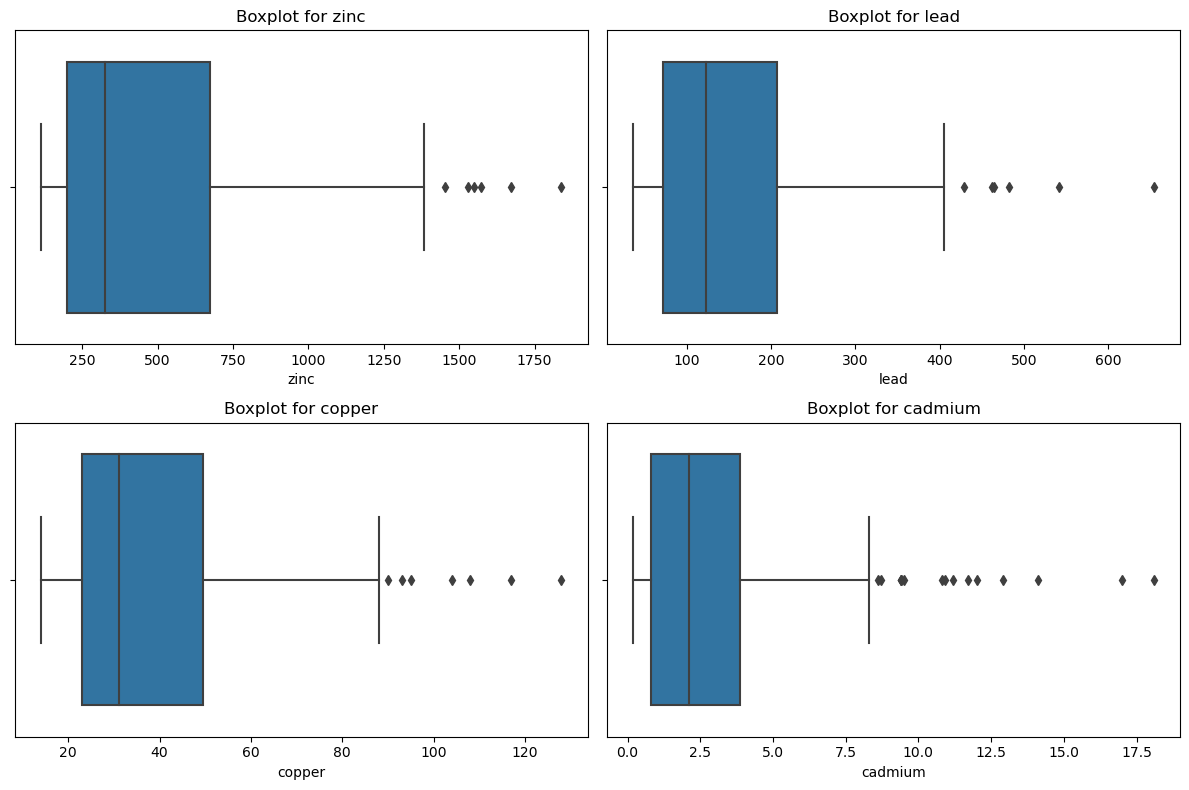

In [9]:
Data = meuse_df.copy()
show_outliers(Data,['zinc', 'lead', 'copper', 'cadmium'])
#show_outlier(Data,'copper')
#show_outlier(Data,'lead')
#show_outlier(Data,'cadmium')

In [11]:
Data['zinc'].describe()

count     155.000000
mean      469.716129
std       367.073788
min       113.000000
25%       198.000000
50%       326.000000
75%       674.500000
max      1839.000000
Name: zinc, dtype: float64

In [12]:
Data['copper'].describe()

count    155.000000
mean      40.316129
std       23.680436
min       14.000000
25%       23.000000
50%       31.000000
75%       49.500000
max      128.000000
Name: copper, dtype: float64

### Cleaning by replacement

In [14]:
def remove_outlier(dt,var):
    # Create the dataframe
    cleaned_dt = dt.copy()
    print("Old Shape: ", dt.shape)

    ''' Detection '''
    # IQR
    # Calculate the upper and lower limits
    Q1 = dt[var].quantile(0.25)
    Q3 = dt[var].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5*IQR
    upper_limit = Q3 + 1.5*IQR
    median_value = dt[var].median()
    #mode_value = dt[var].mode() Not sure if should replace with median or mode 

    outlier_indices = np.where((dt[var] < lower_limit) | (dt[var] > upper_limit))[0]
    print("Number of outliers:", len(outlier_indices))
    
    cleaned_dt.loc[outlier_indices, var] = median_value

    # Print the new shape of the DataFrame
    print("New Shape: ", cleaned_dt.shape)
    
    for idx in outlier_indices:
        print(f"Row {idx}: Original Value = {dt.at[idx, var]}, Replaced with Median = {cleaned_dt.at[idx, var]}")
    
    print("Skewness before cleaning:", dt[var].skew())
    print("Skewness after cleaning:", cleaned_dt[var].skew())
    
    return cleaned_dt

### Cleaning by removing completely 

In [15]:
def remove_outlier(dt, var):
    # Create the dataframe
    cleaned_dt = dt.copy()
    print("Old Shape: ", dt.shape)

    ''' Detection '''
    # IQR
    # Calculate the upper and lower limits
    Q1 = dt[var].quantile(0.25)
    Q3 = dt[var].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    outlier_indices = np.where((dt[var] < lower_limit) | (dt[var] > upper_limit))[0]
    print("Number of outliers:", len(outlier_indices))

    # Remove outliers completely
    cleaned_dt = cleaned_dt.drop(index=outlier_indices).reset_index(drop=True)

    # Print the new shape of the DataFrame
    print("New Shape: ", cleaned_dt.shape)

    print("Skewness before cleaning:", dt[var].skew())
    print("Skewness after cleaning:", cleaned_dt[var].skew())

    return cleaned_dt

In [16]:
print("---Cleaning Cadmium---")
cleaned = remove_outlier(Data,'cadmium')

---Cleaning Cadmium---
Old Shape:  (155, 14)
Number of outliers: 15
New Shape:  (140, 14)
Skewness before cleaning: 1.796224721237889
Skewness after cleaning: 1.3172285372033492


In [17]:
print("---Cleaning Copper---")
cleaned1 = remove_outlier(cleaned,'copper')

---Cleaning Copper---
Old Shape:  (140, 14)
Number of outliers: 15
New Shape:  (125, 14)
Skewness before cleaning: 1.3131157738354833
Skewness after cleaning: 1.0899736674310447


In [18]:
print("---Cleaning Zinc---")
cleaned2 = remove_outlier(cleaned1,'zinc')

---Cleaning Zinc---
Old Shape:  (125, 14)
Number of outliers: 0
New Shape:  (125, 14)
Skewness before cleaning: 0.9875610432534779
Skewness after cleaning: 0.9875610432534779


In [19]:
print("---Cleaning Lead---")
meuse_cleaned = remove_outlier(cleaned2,'lead')

---Cleaning Lead---
Old Shape:  (125, 14)
Number of outliers: 2
New Shape:  (123, 14)
Skewness before cleaning: 1.034973206135582
Skewness after cleaning: 0.9706833151722769


## Plotting Spatial distributions of each metal (Cleaned dataset)

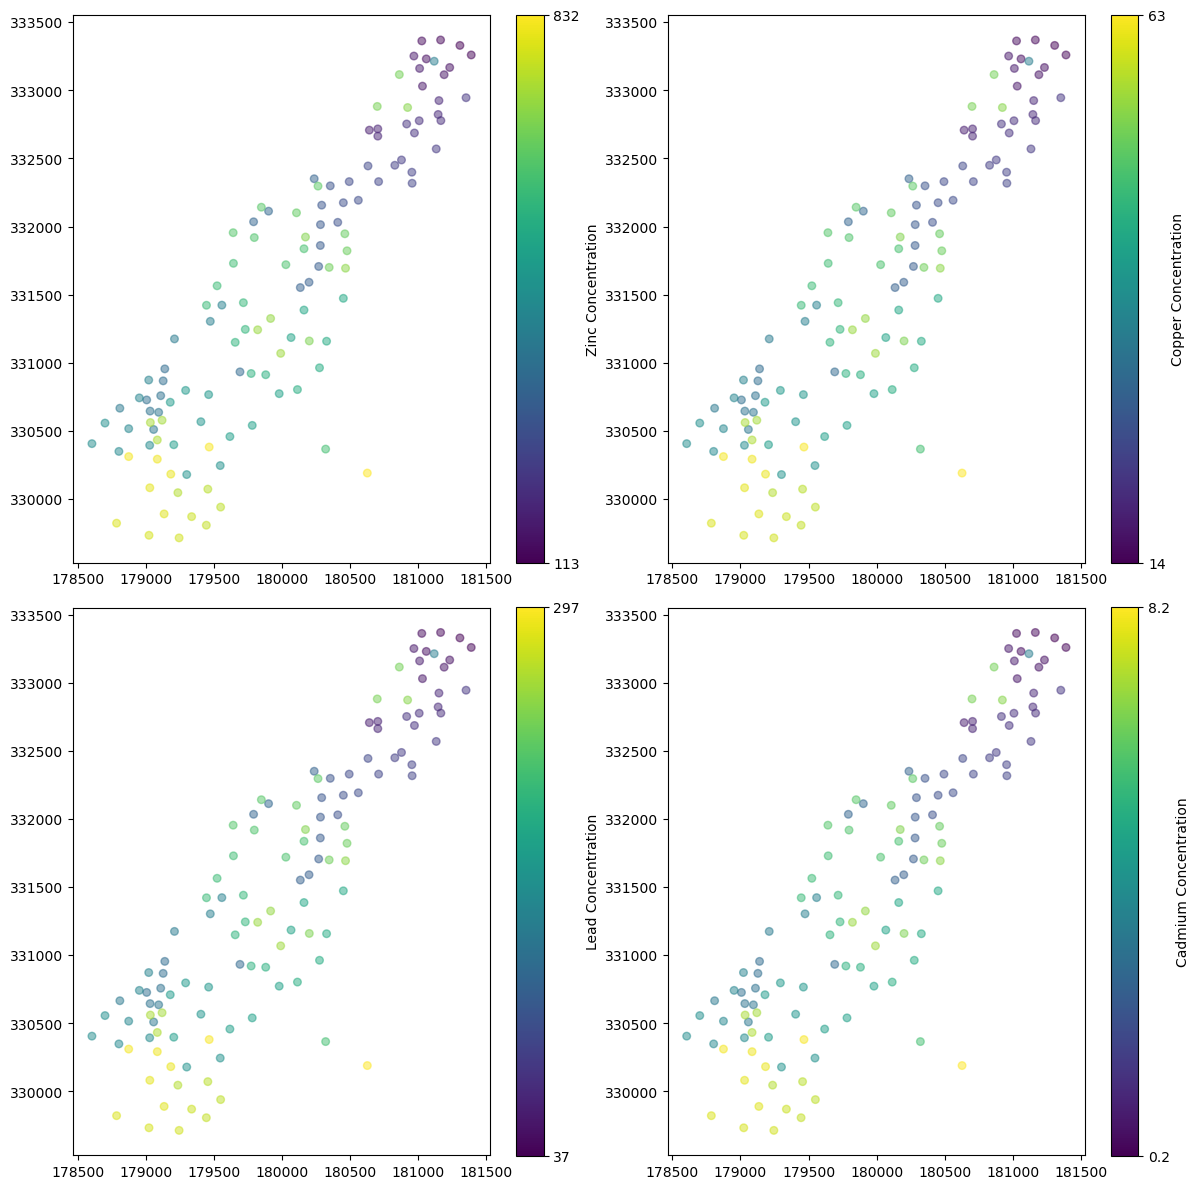

In [20]:
from shapely.geometry import Point
import matplotlib.cm as cm
import matplotlib.colors as colors

# Assuming meuse_cleaned is your DataFrame containing data for different metal elements

# List of metal elements
metal_elements = ['zinc', 'copper', 'lead', 'cadmium']

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.flatten()

for i, metal_element in enumerate(metal_elements):
    metal_values = meuse_cleaned[metal_element]

    # Create a GeoDataFrame for each metal element
    geometry = [Point(xy) for xy in zip(meuse_cleaned['x'], meuse_cleaned['y'])]
    geo_df = gpd.GeoDataFrame(meuse_cleaned, geometry=geometry)

    # Plot the spatial distribution of metal concentrations with colors based on metal values
    scatter_plot = geo_df.plot(ax=axs[i], marker='o', c=metal_values, cmap='viridis', markersize=30, alpha=0.5, legend=True)

    # Create a ScalarMappable to map metal values to colors
    norm = colors.Normalize(vmin=metal_values.min(), vmax=metal_values.max())
    sm = cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])

    # Add colorbar for metal concentrations using ScalarMappable
    cbar = plt.colorbar(sm, ax=axs[i], label=f'{metal_element.capitalize()} Concentration')

    # Set ticks on the colorbar
    cbar.set_ticks([metal_values.min(), metal_values.max()])

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

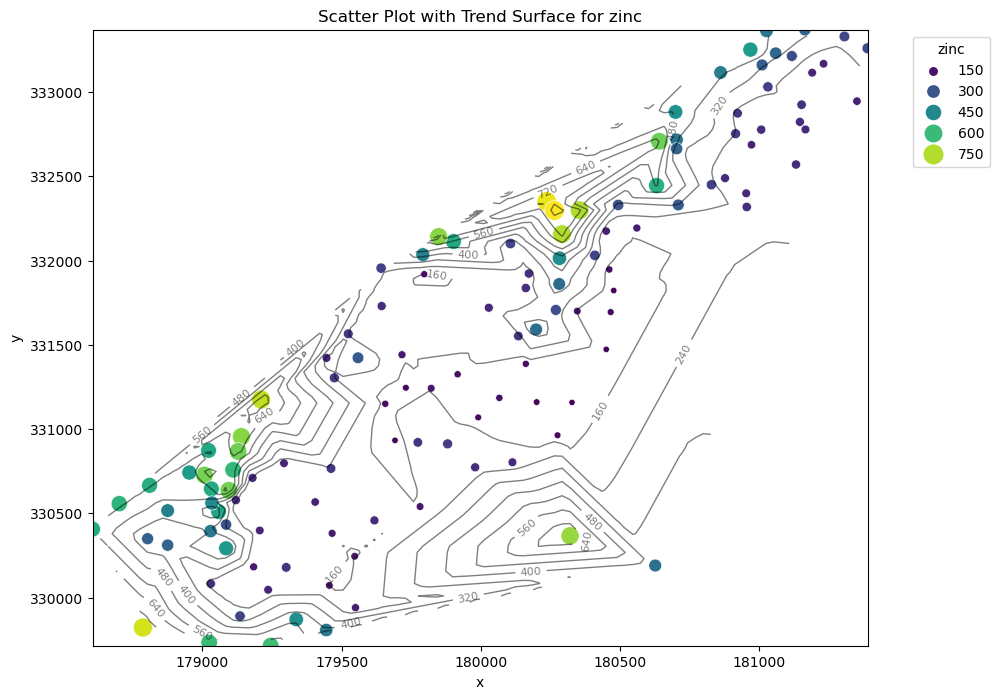

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata


# Select variables of interest
x_variable = 'x'  # Replace with the actual variable name
y_variable = 'y'  # Replace with the actual variable name
z_variable = 'zinc'  # Replace with the actual variable name

# Create a scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x=x_variable, y=y_variable, hue=z_variable, data=meuse_cleaned, palette='viridis', size=z_variable, sizes=(20, 200))

# Add a trend surface using griddata
x_range = np.linspace(meuse_cleaned[x_variable].min(), meuse_cleaned[x_variable].max(), 100)
y_range = np.linspace(meuse_cleaned[y_variable].min(), meuse_cleaned[y_variable].max(), 100)
xx, yy = np.meshgrid(x_range, y_range)
points = np.array(meuse_cleaned[[x_variable, y_variable]])
values = np.array(meuse_cleaned[z_variable])
zz = griddata(points, values, (xx, yy), method='linear')

# Contour plot of the trend surface
contour = plt.contour(xx, yy, zz, levels=10, colors='black', linewidths=1, alpha=0.5)
plt.clabel(contour, inline=True, fontsize=8)

plt.title(f'Scatter Plot with Trend Surface for {z_variable}')
plt.xlabel(x_variable)
plt.ylabel(y_variable)
plt.legend(title=z_variable, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Relationship between the different metals (Cleaned dataset)

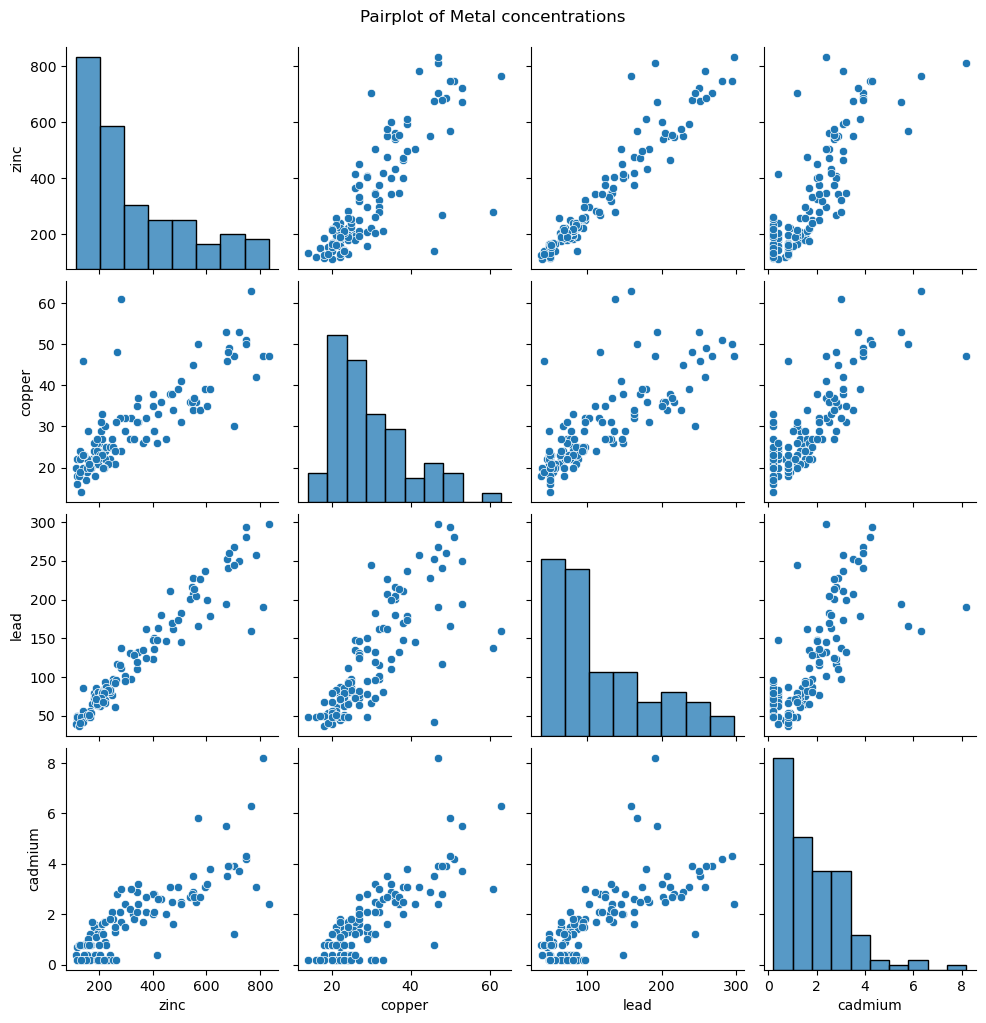

In [22]:
# Pairplot for the metal elements
selected_vars = ['zinc', 'copper', 'lead', 'cadmium']
sns.pairplot(meuse_cleaned[selected_vars])
plt.suptitle('Pairplot of Metal concentrations', y=1.02)
plt.show()

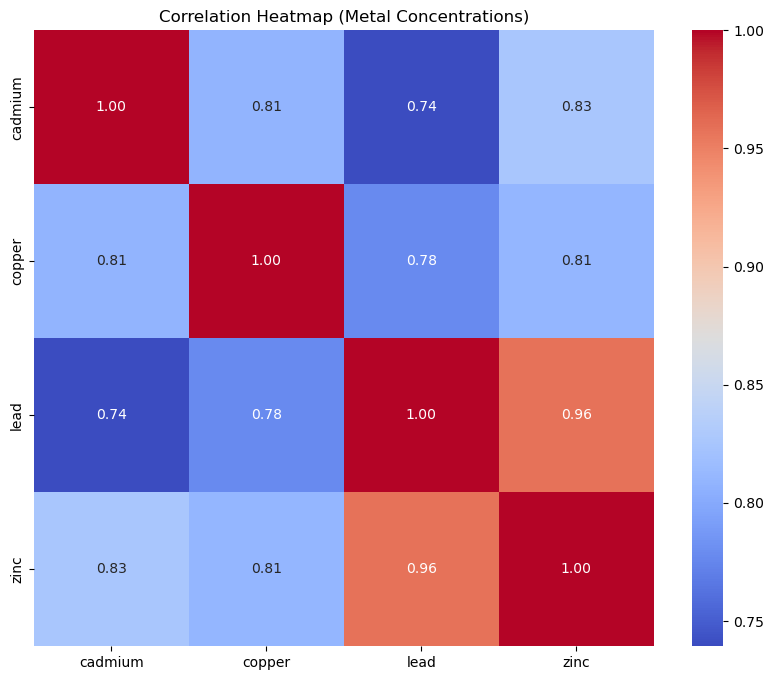

In [23]:
# Correlation heatmap 
selected_variables = ['cadmium', 'copper', 'lead', 'zinc'] 

# Subset the DataFrame based on selected variables
selected_data = meuse_cleaned[selected_variables]

# Calculate the correlation matrix for selected variables
correlation_matrix = selected_data.corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap (Metal Concentrations)')
plt.show()


In [19]:
meuse_cleaned.describe()

,x,y,cadmium,copper,lead,zinc,elev,dist,om,ffreq,soil,lime,dist.m
count,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,121.000000,123.000000,123.000000,123.000000,123.000000
mean,179992.747967,331503.268293,1.765041,29.804878,116.585366,326.617886,8.442797,0.289066,6.247934,1.764228,1.560976,0.130081,347.479675
std,757.104943,1035.001426,1.426045,10.038988,67.314399,192.320878,0.964961,0.185895,2.210358,0.747469,0.667100,0.337769,209.568618
min,178605.000000,329714.000000,0.200000,14.000000,37.000000,113.000000,5.700000,0.001358,1.000000,1.000000,1.000000,0.000000,10.000000
25%,179297.000000,330607.000000,0.550000,22.000000,65.500000,186.500000,7.800500,0.130247,4.800000,1.000000,1.000000,0.000000,160.000000
50%,179991.000000,331423.000000,1.500000,27.000000,87.000000,241.000000,8.507000,0.266220,6.200000,2.000000,1.000000,0.000000,330.000000
75%,180629.500000,332330.000000,2.650000,35.000000,160.500000,441.500000,9.042000,0.391242,7.500000,2.000000,2.000000,0.000000,480.000000
max,181390.000000,333370.000000,8.200000,63.000000,297.000000,832.000000,10.520000,0.880389,12.800000,3.000000,3.000000,1.000000,1000.000000


## Plotting Spatial distributions of each metal (Original dataset)

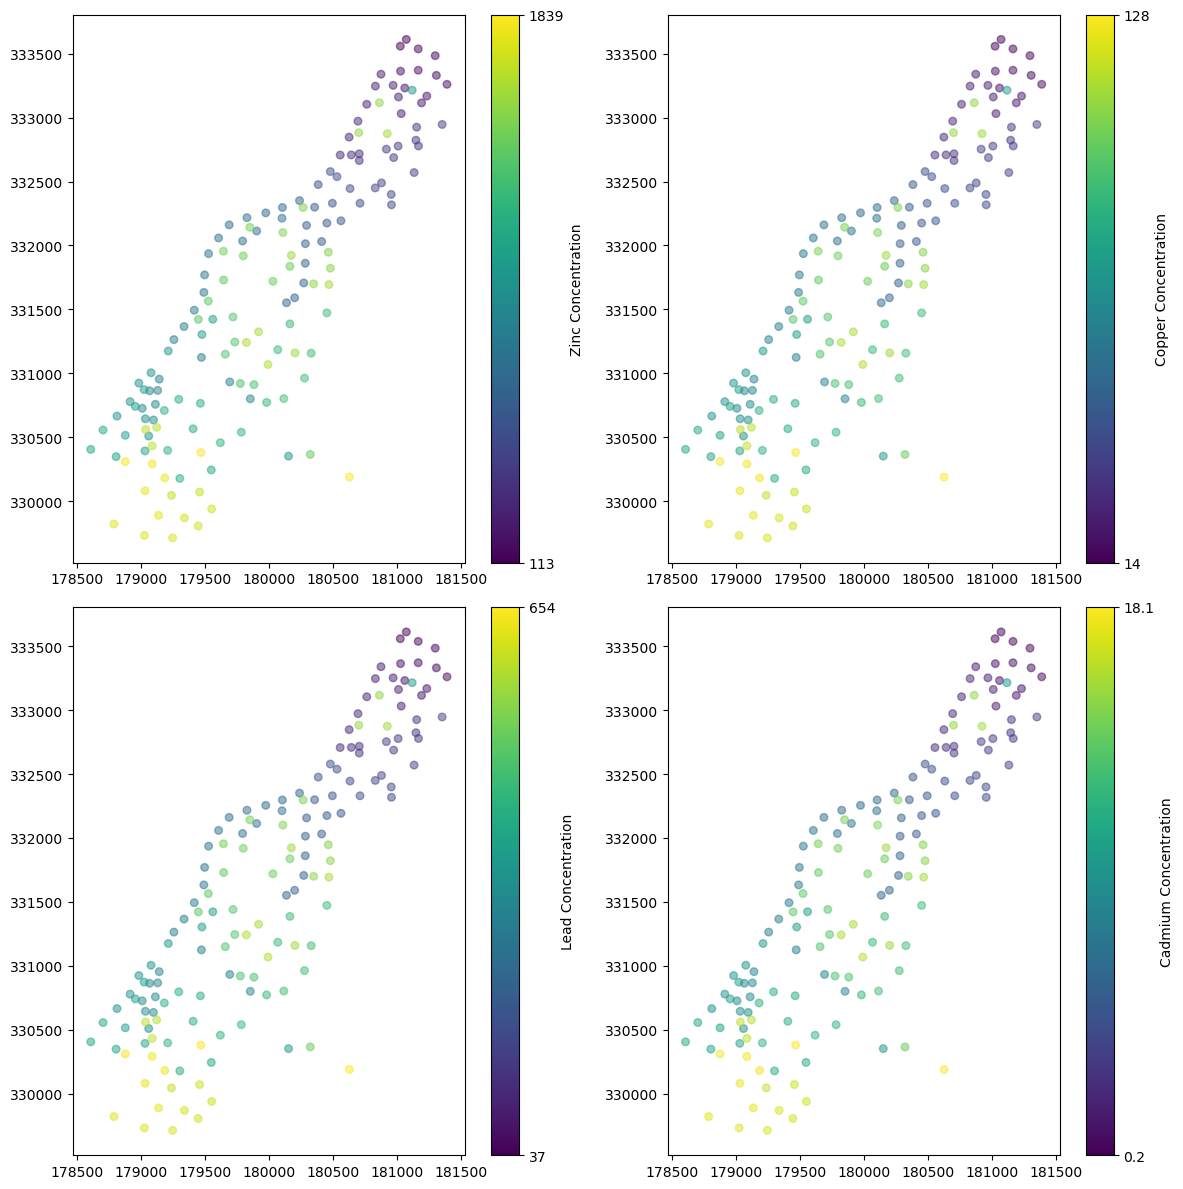

In [25]:
metal_elements = ['zinc', 'copper', 'lead', 'cadmium']

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.flatten()

for i, metal_element in enumerate(metal_elements):
    metal_values = meuse_df[metal_element]

    # Create a GeoDataFrame for each metal element
    geometry = [Point(xy) for xy in zip(meuse_df['x'], meuse_df['y'])]
    geo_df = gpd.GeoDataFrame(meuse_df, geometry=geometry)

    # Plot the spatial distribution of metal concentrations with colors based on metal values
    scatter_plot = geo_df.plot(ax=axs[i], marker='o', c=metal_values, cmap='viridis', markersize=30, alpha=0.5, legend=True)

    # Create a ScalarMappable to map metal values to colors
    norm = colors.Normalize(vmin=metal_values.min(), vmax=metal_values.max())
    sm = cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])

    # Add colorbar for metal concentrations using ScalarMappable
    cbar = plt.colorbar(sm, ax=axs[i], label=f'{metal_element.capitalize()} Concentration')

    # Set ticks on the colorbar
    cbar.set_ticks([metal_values.min(), metal_values.max()])

# Adjust layout and display the plot
plt.tight_layout()
plt.show()



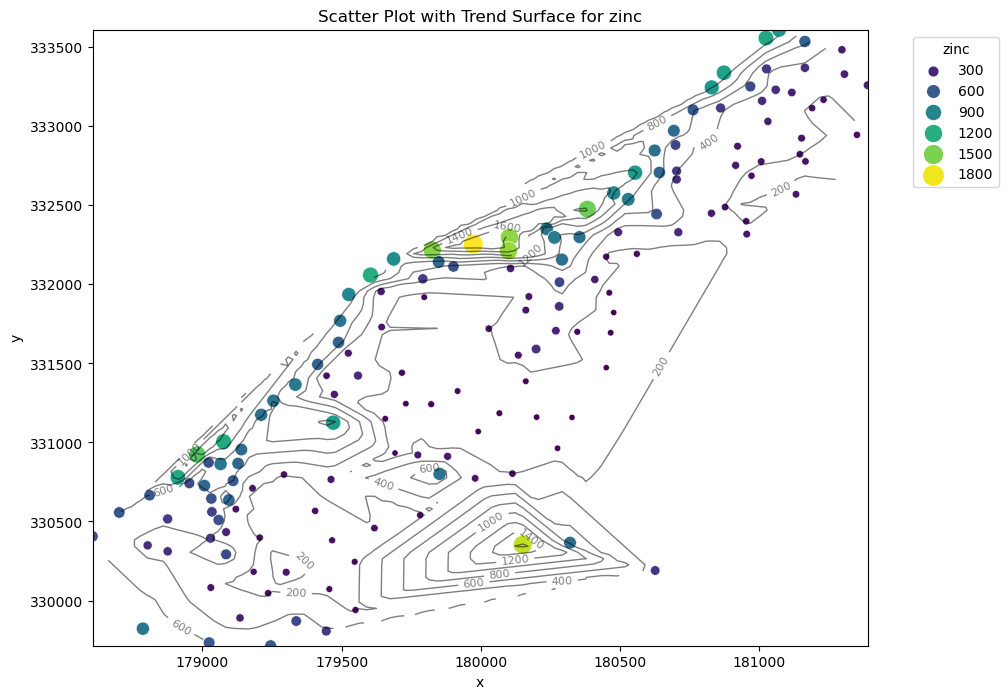

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata


# Select variables of interest
x_variable = 'x'  # Replace with the actual variable name
y_variable = 'y'  # Replace with the actual variable name
z_variable = 'zinc'  # Replace with the actual variable name

# Create a scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x=x_variable, y=y_variable, hue=z_variable, data=meuse_df, palette='viridis', size=z_variable, sizes=(20, 200))

# Add a trend surface using griddata
x_range = np.linspace(meuse_df[x_variable].min(), meuse_df[x_variable].max(), 100)
y_range = np.linspace(meuse_df[y_variable].min(), meuse_df[y_variable].max(), 100)
xx, yy = np.meshgrid(x_range, y_range)
points = np.array(meuse_df[[x_variable, y_variable]])
values = np.array(meuse_df[z_variable])
zz = griddata(points, values, (xx, yy), method='linear')

# Contour plot of the trend surface
contour = plt.contour(xx, yy, zz, levels=10, colors='black', linewidths=1, alpha=0.5)
plt.clabel(contour, inline=True, fontsize=8)

plt.title(f'Scatter Plot with Trend Surface for {z_variable}')
plt.xlabel(x_variable)
plt.ylabel(y_variable)
plt.legend(title=z_variable, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Relationship between the different metals (Original dataset)

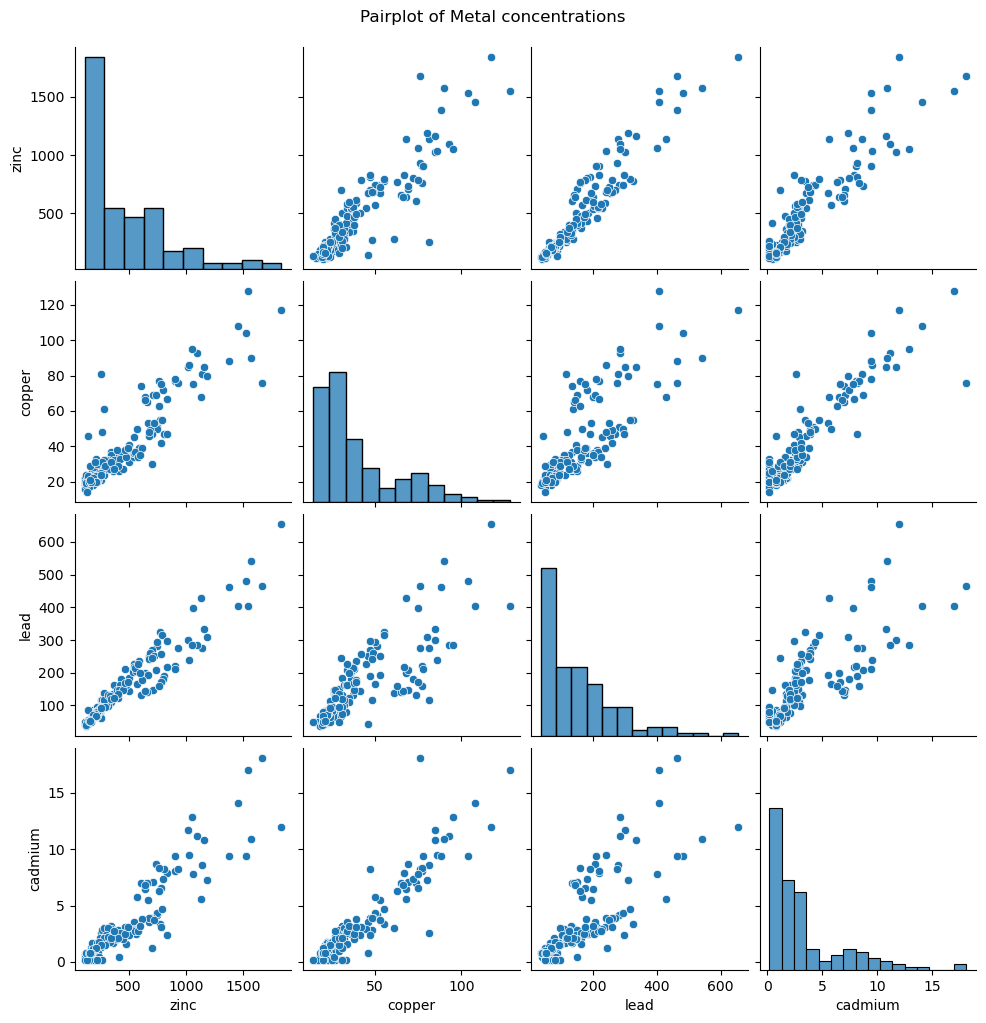

In [12]:
# Pairplot for the metal elements
selected_vars = ['zinc', 'copper', 'lead', 'cadmium']
sns.pairplot(meuse_df[selected_vars])
plt.suptitle('Pairplot of Metal concentrations', y=1.02)
plt.show()

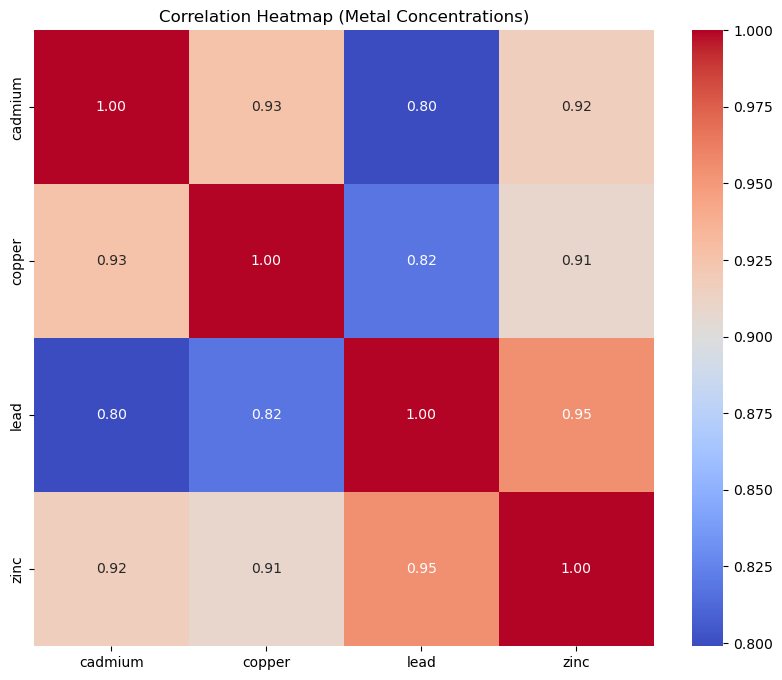

In [24]:
# Correlation heatmap 
selected_variables = ['cadmium', 'copper', 'lead', 'zinc'] 

# Subset the DataFrame based on selected variables
selected_data = meuse_df[selected_variables]

# Calculate the correlation matrix for selected variables
correlation_matrix = selected_data.corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap (Metal Concentrations)')
plt.show()

In [68]:
meuse_df.describe()

,x,y,cadmium,copper,lead,zinc,elev,dist,om,ffreq,soil,lime,dist.m
count,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,153.000000,155.000000,155.000000,155.000000,155.000000
mean,180004.600000,331634.935484,3.245806,40.316129,153.361290,469.716129,8.165394,0.240017,7.478431,1.606452,1.451613,0.283871,290.322581
std,746.039775,1047.746801,3.523746,23.680436,111.320054,367.073788,1.058657,0.197702,3.432966,0.734111,0.636483,0.452336,226.799927
min,178605.000000,329714.000000,0.200000,14.000000,37.000000,113.000000,5.180000,0.000000,1.000000,1.000000,1.000000,0.000000,10.000000
25%,179371.000000,330762.000000,0.800000,23.000000,72.500000,198.000000,7.546000,0.075687,5.300000,1.000000,1.000000,0.000000,80.000000
50%,179991.000000,331633.000000,2.100000,31.000000,123.000000,326.000000,8.180000,0.211843,6.900000,1.000000,1.000000,0.000000,270.000000
75%,180629.500000,332463.000000,3.850000,49.500000,207.000000,674.500000,8.955000,0.364067,9.000000,2.000000,2.000000,1.000000,450.000000
max,181390.000000,333611.000000,18.100000,128.000000,654.000000,1839.000000,10.520000,0.880389,17.000000,3.000000,3.000000,1.000000,1000.000000


In [25]:
meuse_df['x']

0      181072
1      181025
2      181165
3      181298
4      181307
        ...  
150    179184
151    179085
152    178875
153    179466
154    180627
Name: x, Length: 155, dtype: int64

In [26]:
meuse_df['y']

0      333611
1      333558
2      333537
3      333484
4      333330
        ...  
150    330182
151    330292
152    330311
153    330381
154    330190
Name: y, Length: 155, dtype: int64